# RECONNAISSANCE AUTOMATIQUE DE PERSONNAGES BASÉE SUR LES RÉSEAUX DE NEURONES

## Utilisation de Jupyter Notebook

Le principe est simple : 
 - Chaque notebook est constitué d’une liste de **cellules**
 - Chacune peut contenir du **texte formaté** ou du **code** (Python, dans notre cas)
 - On **exécute** une cellule de code -> le résultat s’affiche sous la cellule

Cliquez sur le menu **Help** pour un tour rapide de l’interface.    

Pour vous entraîner :
- **Insérez** quelques cellules de code au début du notebook
- Exécutez quelques commandes Python, telles que **print("Hello world!")** :
    - Cliquez dans une cellule de code et saisissez le code à exécuter
    - Exécutez le code de la cellule en tapant Shift-Entrée ou en cliquant sur le bouton d’exécution
    
Lorsque vous **cliquez** à l’intérieur d’une cellule, vous passez en mode **édition** (la cellule est alors encadrée en *vert*). Lorsque vous tapez la **touche Echap** (Esc) ou que vous cliquez juste à gauche de la cellule, vous passez en mode **commande** (la cellule est alors encadrée en *bleu*). 

Lorsque vous êtes en **mode commande**, tapez la **touche H** pour afficher les nombreux **raccourcis clavier** disponibles

## Construction de la base de données d'apprentissage

1. Utiliser votre google drive pour charger les photos d'Asterix et Obelix dans un dossier ```Data/Asterix``` et ```Data/Obelix```

2. Importer les bonnes bibliothèques python

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras

from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.metrics import Recall,Precision

3. Mettre le chemin vers vos images disponibles sur votre Google Drive et charger les images en divisant **données d'entraineemnt** et **données d'apprentissage**

Pour plus d'information sur la méthode `image_dataset_from_directory`, voir la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [3]:
data_dir  = './drive/MyDrive/data2/' 
img_size=50
batch_size=64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
     seed=200,
    image_size=(img_size, img_size),
    batch_size=batch_size,
)

Found 4154 files belonging to 2 classes.
Using 3324 files for training.
Using 830 files for validation.


In [4]:
# Affichage des classes
class_names = train_ds.class_names
print(class_names)

['asterix', 'obelix']


4. Affichage de quelques images tests et de leur classe

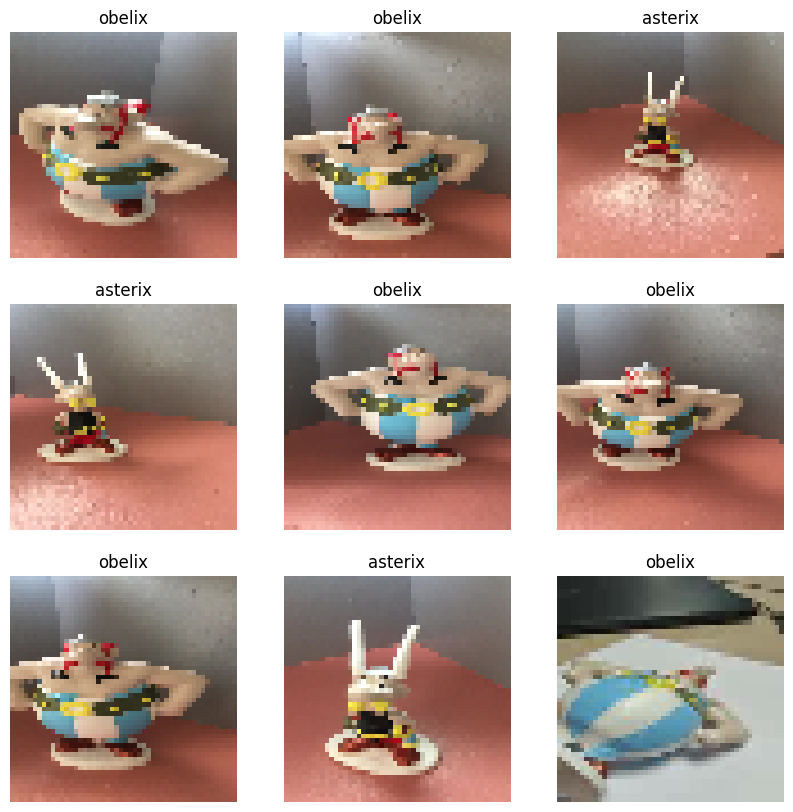

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [6]:
# Vérification de l'utilisation du GPU
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.11.0
/device:GPU:0
Num GPUs Available:  1


5. Faire de l'augmentation de donnée d'après la [documentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation)

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_size, img_size),
  layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


6. Définition de l'architecture du réseau de neurones
- **&rarr;** Modifier le **taux d'apprentissage** (`learning_rate`)
- **&rarr;** Modifier le **nombre d'epochs** (`epochs`)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/4
52/52 [==============================] - 253s 1s/step - loss: 2.8835 - accuracy: 0.9477 - precision: 0.9422 - recall: 0.9546 - val_loss: 0.0498 - val_accuracy: 0.9928 - val_precision: 0.9855 - val_recall: 1.0000
Epoch 2/4
52/52 [==============================] - 20s 130ms/step - loss: 0.8932 - accuracy: 0.9681 - precision: 0.9711 - recall: 0.9653 - val_loss: 0.3602 - val_accuracy: 0.9952 - val_precision: 0.9927 - val_recall: 0.9976
Epoch 3/4
52/52 [==============================] - 20s 130ms/step - loss: 1.7763 - accuracy: 0.9741 - precision: 0.9760 - recall: 0.9725 - val_loss: 0.0855 - val_accuracy: 0.9928 - val_precision: 0.9855 - val_recall: 1.0000
Epoch 4/4
52/52 [==============================] - 20s 131ms/step - loss: 0.7262 - accuracy: 0.9735 - precision: 0.9709 - recall: 0.9767 - val_loss: 0.0761 - val_accuracy: 0.9940 - val_precision: 0.9879 - val_recall: 1.0000


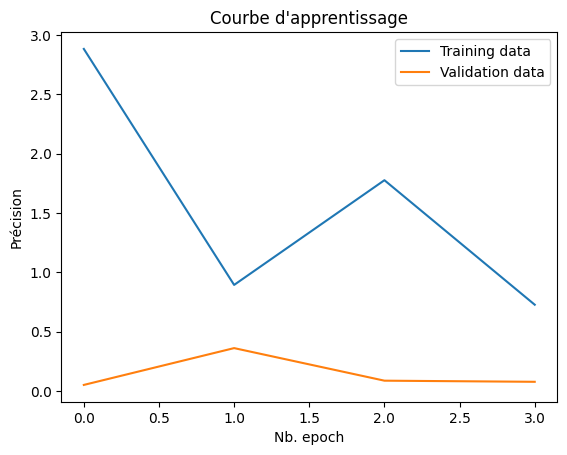

Elapsed 324.152 seconds.


In [8]:
base_model = tf.keras.applications.vgg19.VGG19(input_shape=(img_size,img_size,3), 
                         include_top=False,
                         weights="imagenet")
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))


# Model Compile 

OPT    = tf.keras.optimizers.Adam(learning_rate=1)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy',Precision(),Recall()],
              optimizer=OPT)

import time
start = time.perf_counter()
model_history=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 4,
                        verbose = 1)
elapsed = time.perf_counter() - start


## Afficheage
plt.plot(model_history.history['loss'], label='Training data')
plt.plot(model_history.history['val_loss'], label='Validation data')
plt.title("Courbe d'apprentissage")
plt.ylabel('Précision')
plt.xlabel('Nb. epoch')
plt.legend(loc="upper right")
plt.show()
print('Elapsed %.3f seconds.' % elapsed)

In [9]:
# Prédire l'appartenance à une classe d'une image
def predict_class(image):  
    inference=model.predict((tf.expand_dims(tf.image.resize(image,(img_size,img_size)),axis=0)))
    predicted_class_indices = np.round(inference)
    return predicted_class_indices

7. Mettre de nouvelles images mises dans un autre dossier

In [10]:
test_dir  = './drive/MyDrive/validation/' 


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir ,
    image_size=(img_size, img_size),
)

Found 37 files belonging to 2 classes.


8. Tester ces nouvelles images

1/1 [==============================] - 0s 22ms/step


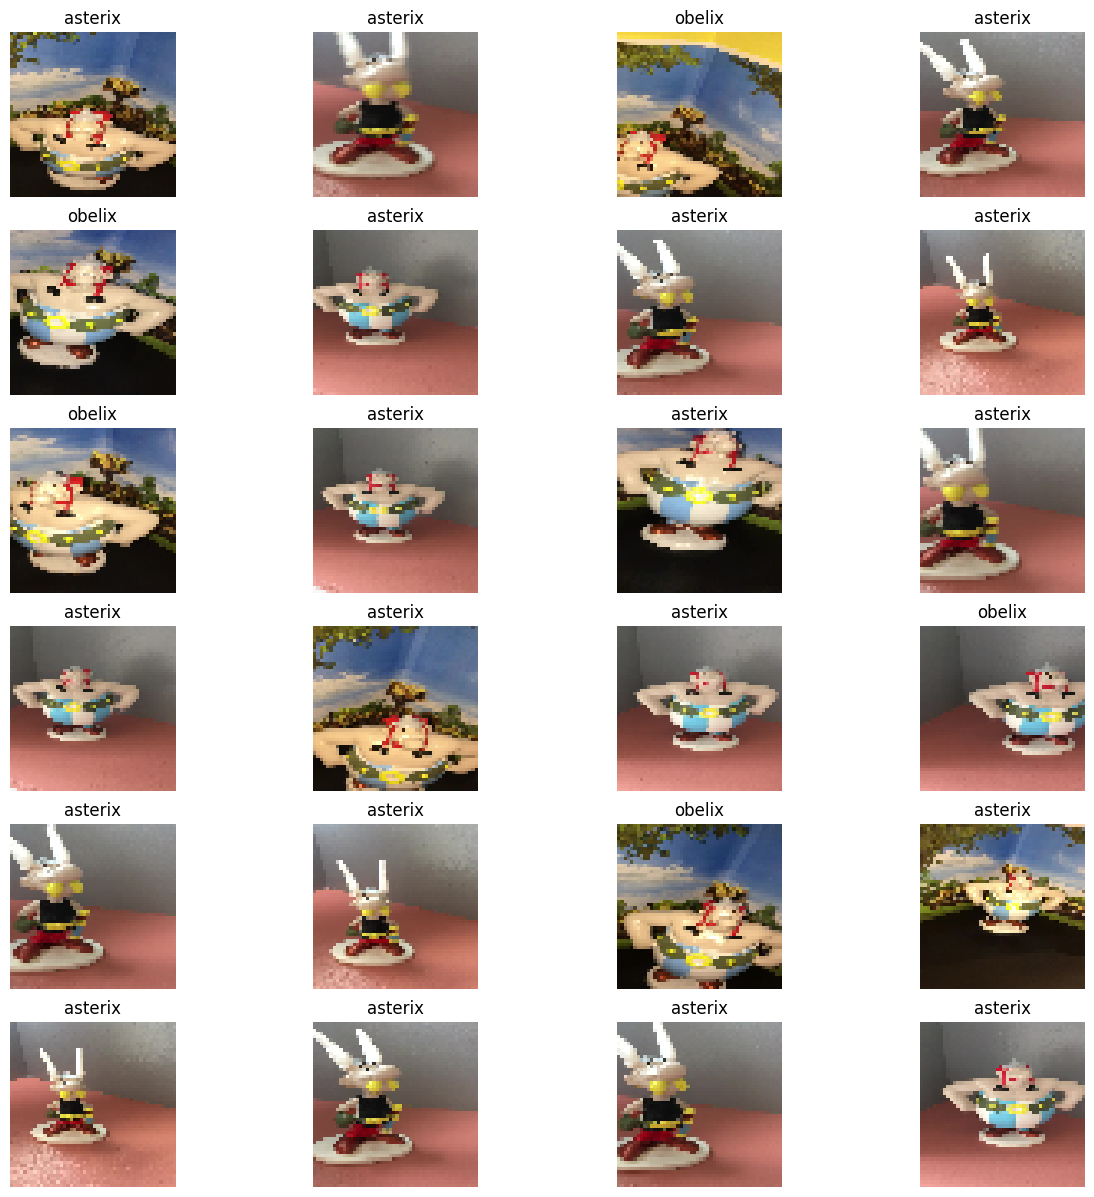

In [11]:
fig = plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(24):
    ax = plt.subplot(6, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    class_number=predict_class(images[i]).astype(int).item()
    plt.title(class_names[class_number])

